In [284]:
import pandas as pd
import lightkurve as lk
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.timeseries import LombScargle
from astropy.table import Table
from scipy.signal import savgol_filter as savgol
from pathlib import Path
from scipy import ndimage

from astropy.table import Table 
from astropy.io import fits

import astropy.units as u
from astropy.visualization import quantity_support, time_support
time_support()
quantity_support()

import copy
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [285]:
import halophot
print('halophot: {}'.format(halophot.__version__))

halophot: 0.7.6


In [286]:
def remove_outliers(data, max_deviations = 2):
    median = np.nanmedian(data)
    standard_dev = np.std(data)
    data_dist = abs(data - median)
    result = np.where(data_dist < max_deviations * standard_dev, data, median)
    return result

def get_best_freq(time, flux, min_period=4./24., max_period=30.):
    frequency, power = LombScargle(time, flux).autopower(minimum_frequency=1./max_period,
                                                                                         maximum_frequency=1./min_period, 
                                                                                         samples_per_peak=3)
    best_freq = frequency[np.argmax(power)]

    # refine
    for j in range(3):
        ls = LombScargle(time, flux)
        frequency, power = ls.autopower(minimum_frequency=best_freq*(1-1e-3*(3-j)),maximum_frequency=best_freq*(1+1e-3*(3-j)), 
                                                                                         samples_per_peak=500)
        best_freq = frequency[np.argmax(power)]

    falarm = ls.false_alarm_probability(np.max(power))

    return best_freq, ls.power(best_freq,normalization='psd'), falarm

def iterative_sine_fit(time, flux, nmax, min_period=4./24., max_period=30.):
    ff, pp = [], []
    y_fit = 0
    flux2 = copy.copy(flux)

    for j in range(nmax):
        best_freq, maxpower, falarm = get_best_freq(time, flux2)
        
        ff.append(best_freq)
        pp.append(maxpower)
        y_fit += LombScargle(time, flux2-1).model(time, best_freq)
        flux2 = flux - y_fit

    flux_fit = y_fit + np.nanmedian(ydata_right)
        
    return flux_fit, flux2, np.array(ff), np.array(pp)

## Upload data:

In [29]:
name = "98 Tau"
epic_id = "200173870"

#download tess

corr_lc = Table.read('98_tau_corrected_tess_lc.fits')

tess_time = corr_lc['TIME'].data
tess_flux = corr_lc['FLUX']/np.nanmedian(corr_lc['FLUX'])
tess_flux_no_outliers = remove_outliers(tess_flux, 1)

tess_trend_func = poly.Polynomial.fit(tess_time, tess_flux_no_outliers, 3)
tess_trend = tess_trend_func(tess_time)
tess_flux_no_trend = tess_flux - tess_trend + np.nanmedian(tess_trend)

freqs_tess = np.linspace((1/10.),360.,10000) # tess from 10 day period to 360 c/d nyquist
ls_tess = LombScargle(tess_time, tess_flux, normalization='standard')
power_tess = ls_tess.power(freqs_tess)
max_freq_tess = np.round(freqs_tess[power_tess.argmax()], 3)
tess_smothed_periodogram = ndimage.gaussian_filter1d(power_tess,6)



#download halo

corr_lc = Table.read('98_Tau_halo_k2sc.fits')
halo = corr_lc

m = np.isfinite(halo['flux'])
halo = halo[m]
halo_flux = halo['flux']
halo_time = halo['time'].data
halo_corr_flux = halo['flux']

halo_corr_median = np.nanmedian(halo_corr_flux)
halo_normalized_flux = halo_corr_flux/halo_corr_median
halo_corr_no_outliers = remove_outliers(halo_corr_flux)
halo_trend = savgol(halo_corr_no_outliers/halo_corr_median,701,3)

halo_lc = LombScargle(halo_time,halo_corr_flux/halo_corr_median-halo_trend+np.nanmedian(halo_trend),normalization='standard') #+np.nanmedian(halo_trend)
freqs_halo = np.linspace((1/30.),24.,10000) 
power_halo = halo_lc.power(freqs_halo)
max_freq_halo = np.round(freqs_halo[power_halo.argmax()], 3)

halo_smothed_periodogram = ndimage.gaussian_filter1d(power_halo,10)


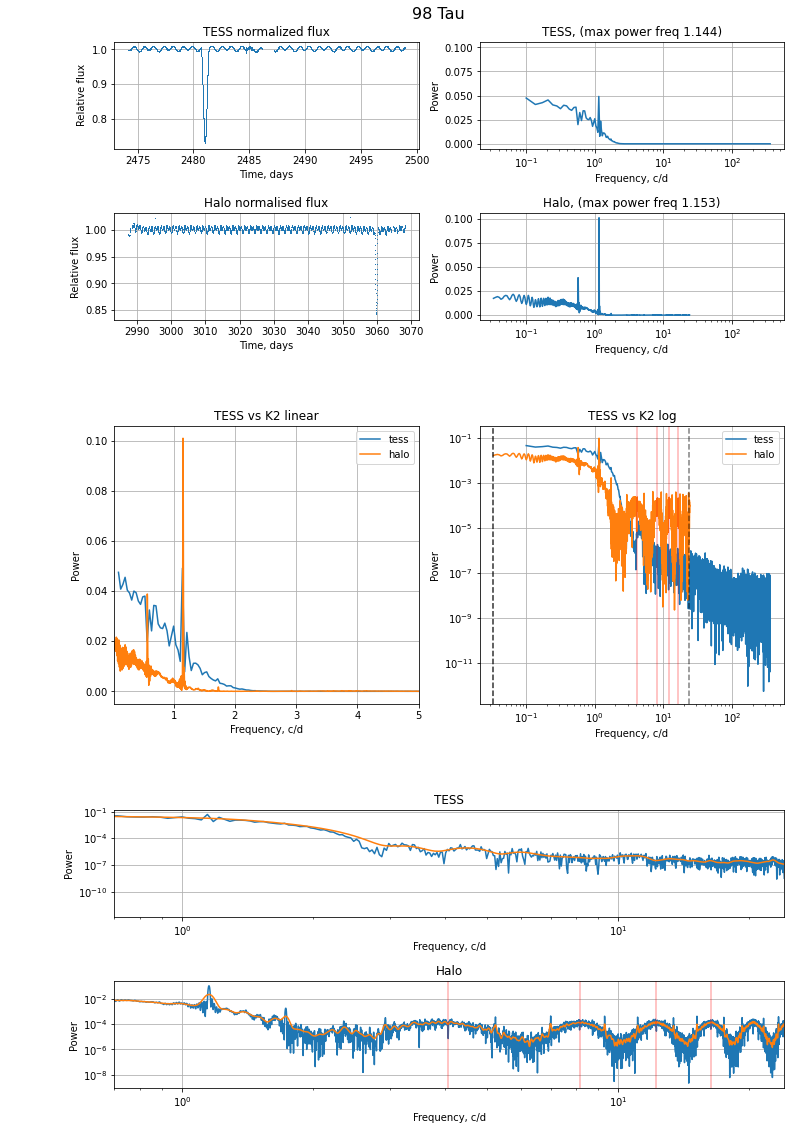

In [30]:
#MAKE PLOTS 

fig = plt.figure(figsize=(12.0,16))
fig.subplots_adjust(top=0.85)

fig.suptitle(name, fontsize=16)

figs = fig.subfigures(nrows=3, ncols=1)

fig1 = figs[0]
fig1.subplots_adjust(hspace=0.6)
ax1 = fig1.add_subplot(221)
#plt.plot(tess_time, tess_flux, ',')
plt.plot(tess_time, tess_flux_no_trend, ',')
#plt.plot(tess_time, tess_flux_no_outliers, ',')
#plt.plot(tess_time, tess_trend, ',')
plt.yscale('linear')
plt.ylabel('Relative flux')
plt.xlabel('Time, days')
plt.title('TESS normalized flux')
plt.grid(True)
ax2 = fig1.add_subplot(222)
plt.plot(freqs_tess, power_tess)
plt.xscale('log')
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.title('TESS, (max power freq %s)' %max_freq_tess)
plt.grid(True)
ax3 = fig1.add_subplot(223)
plt.plot(halo_time, halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend), ',')
plt.yscale('linear')
plt.ylabel('Relative flux')
plt.xlabel('Time, days')
plt.title('Halo normalised flux')
plt.grid(True)
ax4 = fig1.add_subplot(224, sharex=ax2, sharey=ax2)
plt.plot(freqs_halo, power_halo)
plt.xscale('log')
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.title('Halo, (max power freq %s)' %max_freq_halo)
plt.grid(True)
fig2 = figs[1]
ax8 = fig2.add_subplot(121)
plt.plot(freqs_tess, power_tess, label="tess")
plt.plot(freqs_halo, power_halo, label="halo")
plt.xlim(1/30., 5.)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right", )
plt.title('TESS vs K2 linear')
plt.grid(True)
ax9 = fig2.add_subplot(122)
plt.plot(freqs_tess, power_tess, label="tess")
plt.plot(freqs_halo, power_halo, label="halo")
plt.legend(loc="upper right", )
plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
plt.axvline(24., alpha=0.5,linestyle='--',color='k') 
#thruster fire harmonics
plt.axvline(1/30., alpha=0.5,linestyle='--',color='k')
plt.axvline(4.08, alpha=0.3,linestyle='-',color='r')
plt.axvline(8.16, alpha=0.3,linestyle='-',color='r')
plt.axvline(12.24, alpha=0.3,linestyle='-',color='r')
plt.axvline(16.32, alpha=0.3,linestyle='-',color='r')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.title('TESS vs K2 log')
plt.grid(True)


fig3 = figs[2]
#fig3.suptitle('Smoothed', fontsize=16)
ax5 = fig3.add_subplot(211)
plt.plot(freqs_tess, power_tess, freqs_tess, tess_smothed_periodogram)
plt.xlim(0.7, 24.)
plt.xscale('log')
plt.yscale('log')
plt.title('TESS')
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.grid(True)
ax6 = fig3.add_subplot(212)
plt.plot(freqs_halo, power_halo, freqs_halo, halo_smothed_periodogram)
plt.axvline(4.08, alpha=0.3,linestyle='-',color='r')
plt.axvline(8.16, alpha=0.3,linestyle='-',color='r')
plt.axvline(12.24, alpha=0.3,linestyle='-',color='r')
plt.axvline(16.32, alpha=0.3,linestyle='-',color='r')
plt.xlim(0.7, 24.)
plt.xscale('log')
plt.yscale('log')
plt.title('Halo')
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.grid(True)

#pp = PdfPages('reports/%s_%s.pdf' % (epic_id, name))
#pp.savefig(fig)
#pp.close()

In [17]:
type(corr_lc['TIME'])

astropy.table.column.Column

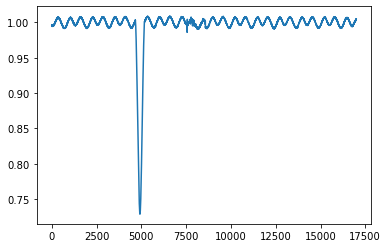

In [28]:
plt.plot(tess_flux_no_trend/np.nanmedian(tess_flux_no_trend))

(0.99, 1.01)

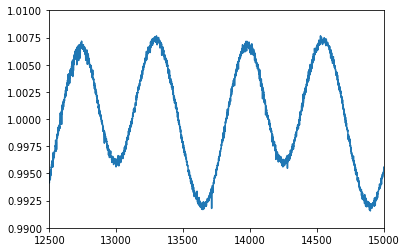

In [31]:
plt.plot(tess_flux)
#plt.plot(tess_trend_reg_cor)
#plt.plot(tess_flux_reg_cor_no_outliers)
#plt.plot(tess_flux_no_trend_reg_cor)
plt.xlim(12500, 15000)
plt.ylim(0.99, 1.01)

## Check eclipse:

(-5.0, 5.0)

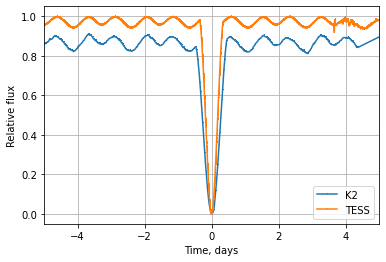

In [34]:
halo_to_plot = halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend)

halo_time_val = halo_time
halo_time_norm = (halo_time_val - np.mean(halo_time_val))
plt.plot((halo_time_norm - halo_time_norm[np.argmin(halo_to_plot)]), (halo_to_plot - min(halo_to_plot))/(max(halo_to_plot) - min(halo_to_plot)), ',-' , label="K2")
plt.yscale('linear')
plt.ylabel('Relative flux')

tess_time_norm = (tess_time - np.mean(tess_time))
plt.plot((tess_time_norm - tess_time_norm[np.argmin(tess_flux)]), (tess_flux - min(tess_flux))/(max(tess_flux) - min(tess_flux)), ',-', label="TESS")
plt.yscale('linear')
plt.ylabel('Relative flux')
plt.xlabel('Time, days')
plt.grid(True)
plt.legend(loc='lower right')

plt.xlim(-5, 5)

(-2.0, 2.0)

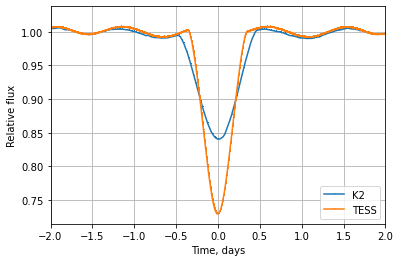

In [36]:
halo_to_plot = halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend)

halo_time_val = halo_time
halo_time_norm = (halo_time_val - np.mean(halo_time_val))
plt.plot((halo_time_norm - halo_time_norm[np.argmin(halo_to_plot)]), halo_to_plot, ',-' , label="K2")
plt.yscale('linear')
plt.ylabel('Relative flux')

tess_time_norm = (tess_time - np.mean(tess_time))
plt.plot((tess_time_norm - tess_time_norm[np.argmin(tess_flux)]), tess_flux, ',-', label="TESS")
plt.yscale('linear')
plt.ylabel('Relative flux')
plt.xlabel('Time, days')
plt.grid(True)
plt.legend(loc='lower right')

plt.xlim(-2, 2)

(0.98, 1.01)

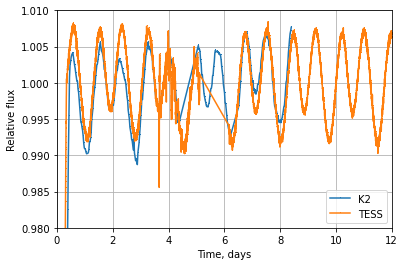

In [38]:
halo_to_plot = halo_corr_flux/np.nanmedian(halo_corr_flux)-halo_trend+np.nanmedian(halo_trend)

#halo_time_norm = (halo_time - np.mean(halo_time))
#plt.plot((halo_time_norm - halo_time_norm[np.argmin(halo_to_plot)]), (halo_to_plot - min(halo_to_plot))/(max(halo_to_plot) - min(halo_to_plot)), ',-' , label="K2")
plt.plot((halo_time_norm - halo_time_norm[np.argmin(halo_to_plot)]), halo_to_plot, ',-' , label="K2")
plt.yscale('linear')
plt.ylabel('Relative flux')

#tess_time_norm = (tess_time_reg_cor - np.mean(tess_time_reg_cor))
#plt.plot((tess_time_norm - tess_time_norm[np.argmin(tess_flux_reg_cor)]), (tess_flux_reg_cor - min(tess_flux_reg_cor))/(max(tess_flux_reg_cor) - min(tess_flux_reg_cor)), ',-', label="TESS")
plt.plot((tess_time_norm - tess_time_norm[np.argmin(tess_flux)]), tess_flux, ',-', label="TESS")
plt.yscale('linear')
plt.ylabel('Relative flux')
plt.xlabel('Time, days')
plt.grid(True)
plt.legend(loc='lower right')

plt.xlim(0, 12)
plt.ylim(0.98, 1.01)

## Noise after eclipse (TESS):

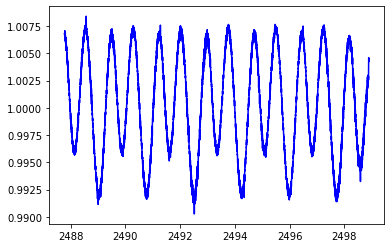

In [72]:
ydata_right = tess_flux[9000:].data
xdata_right = tess_time[9000:]
plt.plot(xdata_right, ydata_right, 'b-', label='data')

[1.15018299 0.57530855]
[0.07775749 0.01112551]


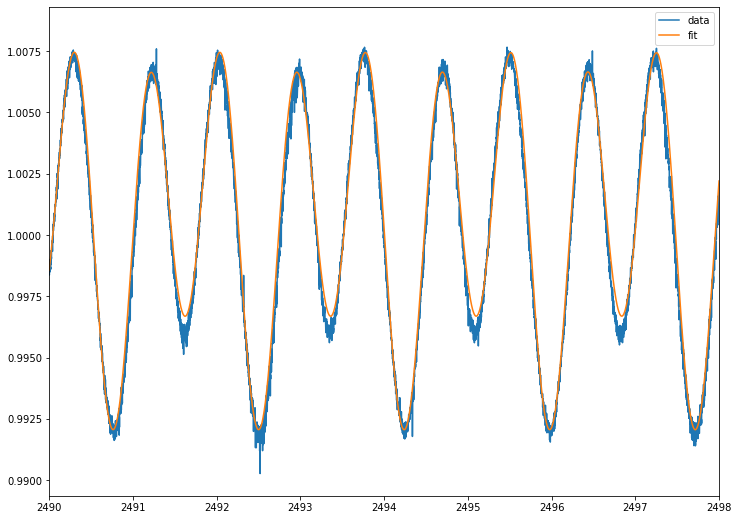

In [73]:
fig = plt.figure(figsize=(12.0,9.0))
y_fit_right, delta_right, ff_right, pp_right = iterative_sine_fit(xdata_right, ydata_right, 2)

plt.plot(xdata_right, ydata_right, label= "data")
plt.plot(xdata_right, y_fit_right, label = "fit")
#plt.plot(xdata_right, delta_data)
#plt.plot(xdata_right, delta_right, label = "residuals")
plt.legend(loc="upper right", )
plt.xlim(2490,2498)
print(ff_right)
print(pp_right)

In [74]:
freqs_tess = np.linspace((1/10.),36.,100000) # tess from 100 day period to 360 c/d nyquist
ls_tess_right = LombScargle(xdata_right, ydata_right, normalization='psd')
power_tess_right = ls_tess_right.power(freqs_tess)

#ls_tess_right = LombScargle(tess_time_reg_cor, tess_flux_reg_cor, normalization='standard')
#freqs_tess_reg_cor, power_tess_right = ls_tess_right.autopower(minimum_frequency=0.1, maximum_frequency=20)
#max_freq_tess_reg_cor = np.round(freqs_tess_reg_cor[power_tess_right.argmax()], 3)
#print(len(freqs_tess_reg_cor))

In [139]:
ls_tess_right.nterms = 2

In [140]:
1/freqs_tess[np.argmax(power_tess_right)]

0.8686870792797817

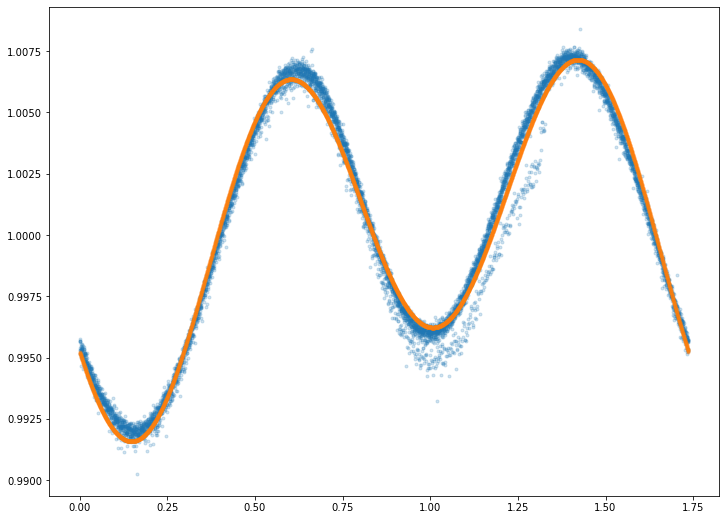

In [141]:
period = 0.8684162534411338
y_fit_right = ls_tess_right.model(xdata_right,1/(2*period))
# y_fit_right, delta_right, ff_right, pp_right = iterative_sine_fit(xdata_right, ydata_right, 2)


fig = plt.figure(figsize=(12.0,9.0))

plt.plot((xdata_right) % (period*2), ydata_right,'.',alpha=0.2 )
plt.plot((xdata_right) % (period*2), y_fit_right,'.',alpha=0.2 )

In [142]:
residuals_right = ydata_right - y_fit_right

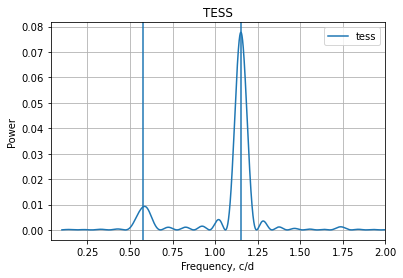

In [143]:
plt.plot(freqs_tess, power_tess_right, label="tess")
plt.axvline(1/period)
plt.axvline(0.5/period)


plt.xlim(1/30., 2)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right", )
plt.title('TESS')
plt.grid(True)

In [144]:
freqs_noise_right = np.linspace((1/10.),20.,1000000) # tess from 10 day period to 360 c/d nyquist
ls_noise_right = LombScargle(xdata_right, residuals_right, normalization='psd', fit_mean=False, center_data=True)
power_noise_right = ls_noise_right.power(freqs_noise_right)

Text(0.5, 1.0, 'Right side from eclipse')

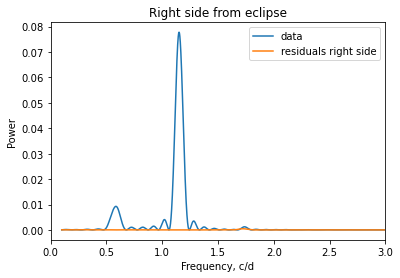

In [145]:
plt.plot(freqs_tess, power_tess_right, label="data")
plt.plot(freqs_noise_right, power_noise_right, label="residuals right side")
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")
plt.title('Right side from eclipse')

Text(0.5, 1.0, 'Right side from eclipse')

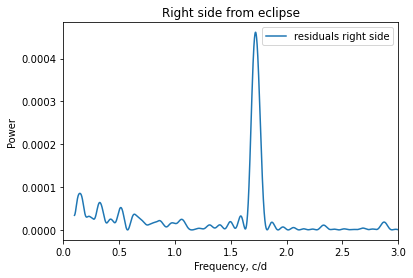

In [146]:
plt.plot(freqs_noise_right, power_noise_right, label="residuals right side")
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")
plt.title('Right side from eclipse')

## Noise before eclipse (TESS):

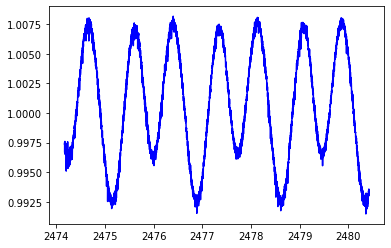

In [147]:
ydata_left = tess_flux[:4500].data
xdata_left = tess_time[:4500]
plt.plot(xdata_left, ydata_left, 'b-', label='data')

[1.15018299 0.57530855]
[0.07775749 0.01112551]


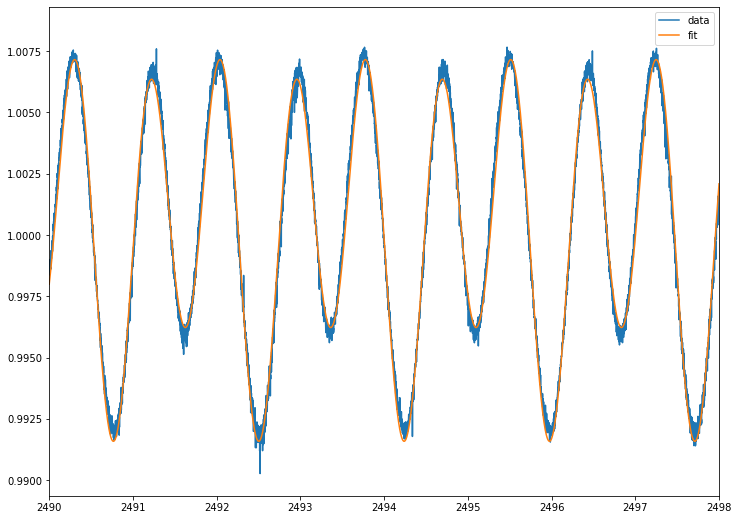

In [148]:
fig = plt.figure(figsize=(12.0,9.0))
y_fit_left, delta_left, ff_left, pp_left = iterative_sine_fit(xdata_left, ydata_left, 2)

plt.plot(xdata_right, ydata_right, label= "data")
plt.plot(xdata_right, y_fit_right, label = "fit")
#plt.plot(xdata_right, delta_data)
#plt.plot(xdata_right, delta_right, label = "residuals")
plt.legend(loc="upper right", )
plt.xlim(2490,2498)
print(ff_right)
print(pp_right)

In [149]:
freqs_tess = np.linspace((1/10.),36.,100000) # tess from 100 day period to 360 c/d nyquist
ls_tess_left = LombScargle(xdata_left, ydata_left, normalization='psd')
power_tess_left = ls_tess_left.power(freqs_tess)

In [150]:
ls_tess_left.nterms = 2

In [151]:
1/freqs_tess[np.argmax(power_tess_left)]

0.8681455964176481

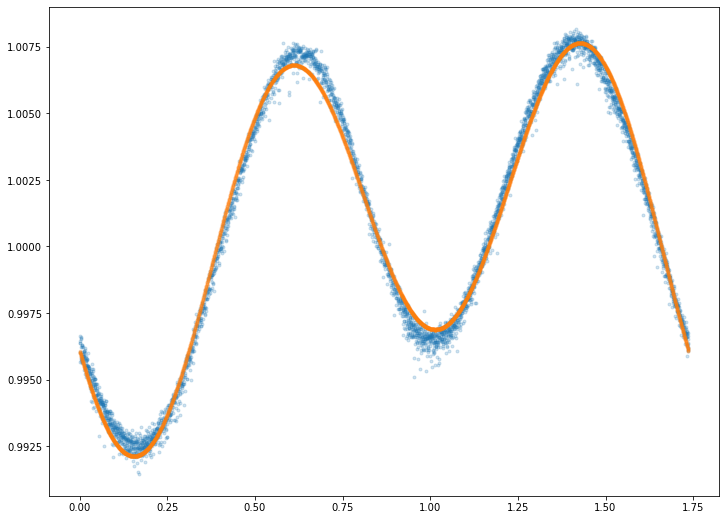

In [152]:
period = 0.8684162534411338
y_fit_left = ls_tess_left.model(xdata_left,1/(2*period))
# y_fit_right, delta_right, ff_right, pp_right = iterative_sine_fit(xdata_right, ydata_right, 2)


fig = plt.figure(figsize=(12.0,9.0))

plt.plot((xdata_left) % (period*2), ydata_left,'.',alpha=0.2 )
plt.plot((xdata_left) % (period*2), y_fit_left,'.',alpha=0.2 )

In [153]:
residuals_left = ydata_left - y_fit_left

In [154]:
freqs_noise_left = np.linspace((1/10.),20.,1000000) # tess from 10 day period to 360 c/d nyquist
ls_noise_left = LombScargle(xdata_left, residuals_left, normalization='psd', fit_mean=False, center_data=True)
power_noise_left = ls_noise_left.power(freqs_noise_left)

Text(0.5, 1.0, 'TESS before eclipse')

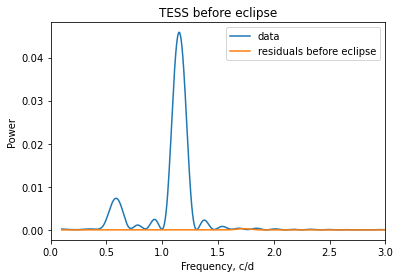

In [275]:
plt.plot(freqs_tess, power_tess_left, label="data")
plt.plot(freqs_noise_left, power_noise_left, label="residuals before eclipse")
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")
plt.title('TESS before eclipse')

Text(0.5, 1.0, 'Right side from eclipse')

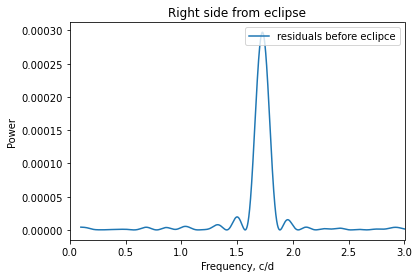

In [156]:
plt.plot(freqs_noise_left, power_noise_left, label="residuals before eclipce")
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")
plt.title('Right side from eclipse')

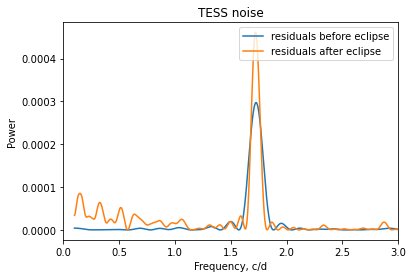

In [157]:
plt.plot(freqs_noise_left, power_noise_left, label="residuals before eclipse")
plt.plot(freqs_noise_right, power_noise_right, label="residuals after eclipse")
plt.title('TESS noise')
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")

In [162]:
best_freq_left = 1/freqs_noise_left[np.argmax(power_tess_left)]
theta_left = ls_noise_left.model_parameters(best_freq_left) 
design_matrix_left = ls_noise_left.design_matrix(best_freq_left, residuals_left)

In [185]:
design_matrix_left[:,0]

array([-0.03131719, -0.02509637, -0.05657647, ...,  0.01183575,
        0.01877897, -0.00185053])

In [202]:
theta_left.shape

(2,)

In [209]:
theta_left.round(9)

array([ 3.181e-06, -5.196e-06])

In [212]:
offset = ls_noise_left.offset()

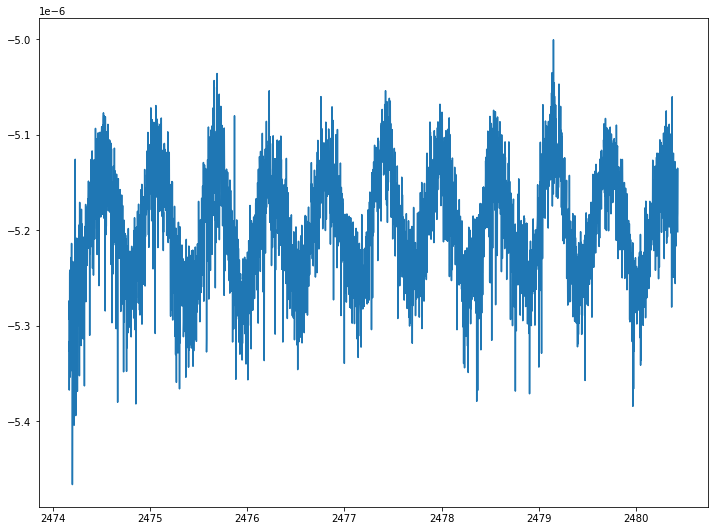

In [214]:
fig = plt.figure(figsize=(12.0,9.0))
plt.plot(xdata_left,theta_left[1,]*design_matrix_left[:,1] + theta_left[0,]*design_matrix_left[:,0] + offset)
#plt.plot(xdata_left, ydata_left, label = "fit")

# Let's check before and after eclipse in K2.
## Noise after eclipse:

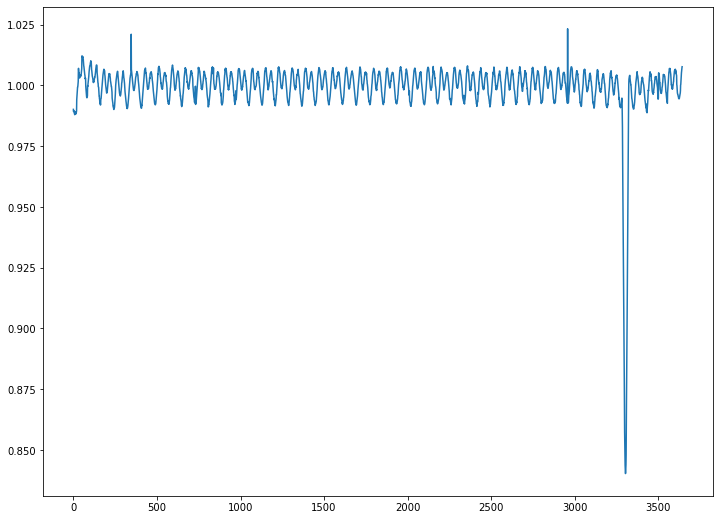

In [215]:
fig = plt.figure(figsize=(12.0,9.0))
plt.plot(halo_to_plot)

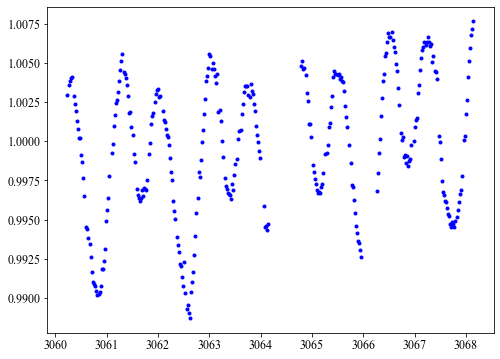

In [401]:
ydata_left_halo = halo_to_plot[3325:]
xdata_left_halo = halo_time[3325:]
plt.plot(xdata_left_halo, ydata_left_halo, 'b.', label='data')

In [431]:
freqs_halo = np.linspace((1/10.),36.,10000) # tess from 100 day period to 360 c/d nyquist
ls_halo_left = LombScargle(xdata_left_halo, ydata_left_halo, normalization='psd',nterms=4)
power_halo_left = ls_halo_left.power(freqs_halo)

In [432]:
ls_halo_left.nterms = 2

In [433]:
1/freqs_halo[np.argmax(power_halo_left)]

3.4448425549507333

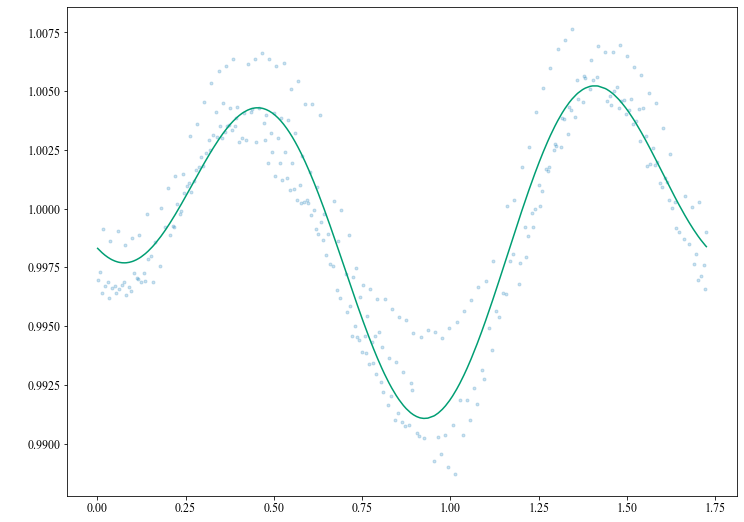

In [434]:
period = 0.8643740356730731
y_fit_left_halo = ls_halo_left.model(xdata_left_halo,1/(2*period))
# y_fit_right, delta_right, ff_right, pp_right = iterative_sine_fit(xdata_right, ydata_right, 2)
phase = (xdata_left_halo) % (period*2)
args = np.argsort(phase)
args2 = np.argsort(args)


fig = plt.figure(figsize=(12.0,9.0))

plt.plot(phase[args], ydata_left_halo[args],'.',alpha=0.2 )
plt.plot(phase[args], y_fit_left_halo[args],'-',alpha=1 )

In [435]:
def normalize(xx):
    # this makes your time stamps go from 0 to 1, for convenients
    return (xx-xx.min())/(xx.max()-xx.min())

dm = ls_halo_left.design_matrix(1/(period)) # use the true period here

basis_v = np.vander(normalize(xdata_left_halo),3)[:,:-1] # vander (short for vandermonde) is a matrix of 1, x, x**2 
# we want to throw away the constant term, which is listed last, because LS has one already
basis = np.hstack([dm,basis_v]) # this makes a combined basis of constant, sines, x, and x**2

soln = np.linalg.lstsq(basis,ydata_left_halo) # this does the inverse square solution

coeffs = soln[0] # lstsq returns the solution, and metadata about the solver

trend = np.dot(basis,coeffs)


basis_ls = np.hstack([dm[:,[0]], basis_v])
coeffs_ls = np.hstack([coeffs[[0]], coeffs[-2:]])

trend_linsq = np.dot(basis_ls, coeffs_ls)

trend_sq = np.dot(basis_v, coeffs[-2:])

ydata_left_halo_no_trend = (ydata_left_halo - trend_sq)/np.nanmedian(ydata_left_halo - trend_sq)

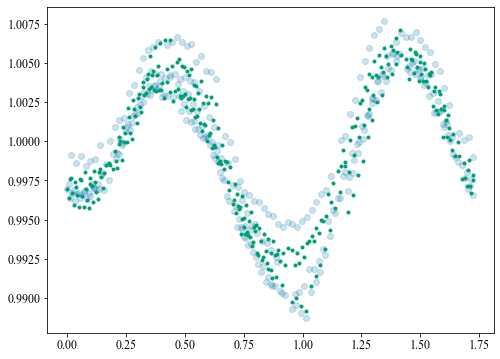

In [436]:

plt.plot((xdata_left_halo) % (period*2), ydata_left_halo,'o',alpha=0.2 )
#plt.plot((xdata_left_halo) % (period*2), y_fit_left_halo,'.',alpha=0.2 )

#plt.plot((xdata_left_halo) % (period*2), trend,'*',alpha=0.5 )

#plt.plot((xdata_left_halo) % (period*2), trend_linsq,'o' )

plt.plot((xdata_left_halo) % (period*2), ydata_left_halo_no_trend, '.')

In [437]:
ydata_left_halo_no_trend = (ydata_left_halo - trend_sq)/np.nanmedian(ydata_left_halo - trend_sq)

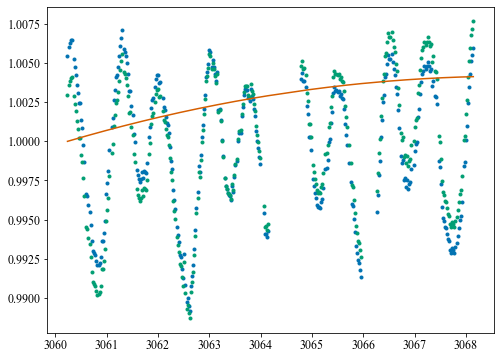

In [438]:
plt.plot(xdata_left_halo,ydata_left_halo_no_trend,'.')
plt.plot(xdata_left_halo,ydata_left_halo,'.')
plt.plot(xdata_left_halo,trend_sq+1)

In [439]:
freqs_halo = np.linspace((1/10.),36.,100000) # tess from 100 day period to 360 c/d nyquist
ls_halo_left_no_trend = LombScargle(xdata_left_halo, ydata_left_halo_no_trend, normalization='psd')
power_halo_left_no_trend = ls_halo_left_no_trend.power(freqs_halo)

In [440]:
ls_halo_left_no_trend.nterms = 2
1/freqs_halo[np.argmax(power_halo_left_no_trend)]

0.8643740356730731

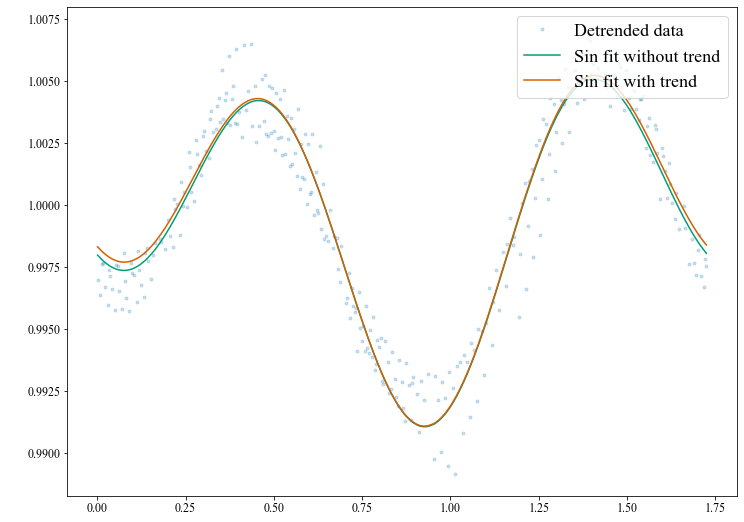

In [441]:
period = 0.8643740356730731
y_fit_left_halo_no_trend = ls_halo_left_no_trend.model(xdata_left_halo,1/(2*period))
# y_fit_right, delta_right, ff_right, pp_right = iterative_sine_fit(xdata_right, ydata_right, 2)

phase = (xdata_left_halo) % (period*2)
args = np.argsort(phase)
fig = plt.figure(figsize=(12.0,9.0))

plt.plot(phase, ydata_left_halo_no_trend,'.',alpha=0.2, label="Detrended data" )
plt.plot(phase[args], y_fit_left_halo_no_trend[args],'-', label="Sin fit without trend" )
plt.plot(phase[args], y_fit_left_halo[args],'-', label="Sin fit with trend" )
plt.legend(loc="upper right")

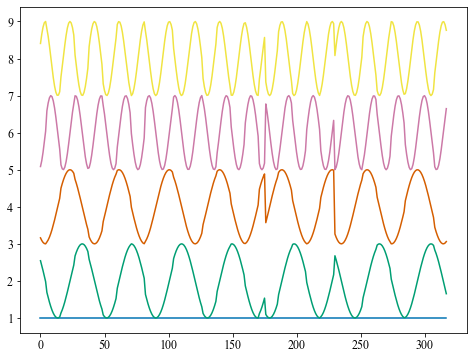

In [446]:
for j in range(5):
    plt.plot(dm[:,j]+j*2)

In [448]:
constant = coeffs[0]
fundamental = np.sqrt(coeffs[1]**2 + coeffs[2]**2)
harmonic = np.sqrt(coeffs[3]**2 + coeffs[4]**2)
print('Constant:',constant)
print('Fundamental: %.2g' % fundamental)
print('Harmonic: %.2g' % harmonic)

Constant: 0.9968839023745706
Fundamental: 0.0049
Harmonic: 5.6e-05


In [384]:
residuals_left_halo = ydata_left_halo_no_trend - y_fit_left_halo

In [385]:
freqs_noise_left_halo = np.linspace((1/10.),20.,1000000) # tess from 10 day period to 360 c/d nyquist
ls_noise_left_halo = LombScargle(xdata_left_halo, residuals_left_halo, normalization='psd', fit_mean=False, center_data=True)
power_noise_left_halo = ls_noise_left_halo.power(freqs_noise_left_halo)

Text(0.5, 1.0, 'Right side from eclipse')

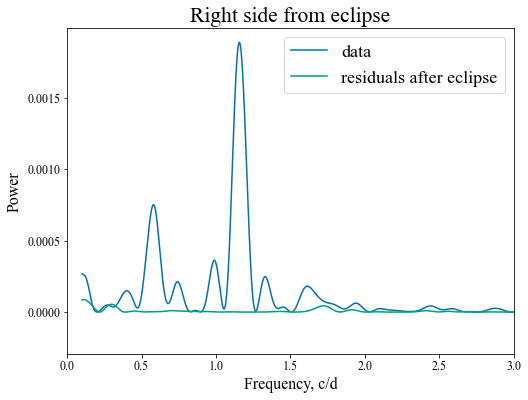

In [386]:
plt.plot(freqs_halo, power_halo_left, label="data")
plt.plot(freqs_noise_left_halo, power_noise_left_halo, label="residuals after eclipse")
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")
plt.title('Right side from eclipse')

Text(0.5, 1.0, 'Right side from eclipse')

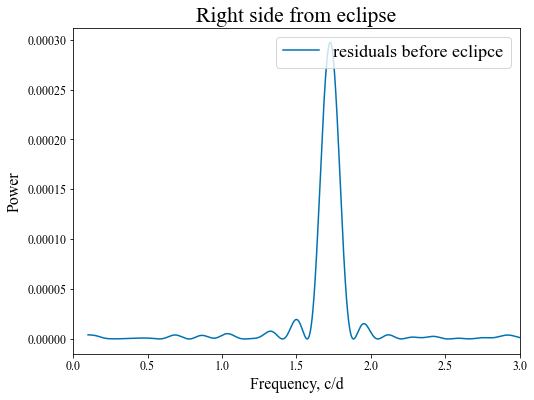

In [387]:
plt.plot(freqs_noise_left, power_noise_left, label="residuals before eclipce")
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")
plt.title('Right side from eclipse')

## Halo noise before eclipse:

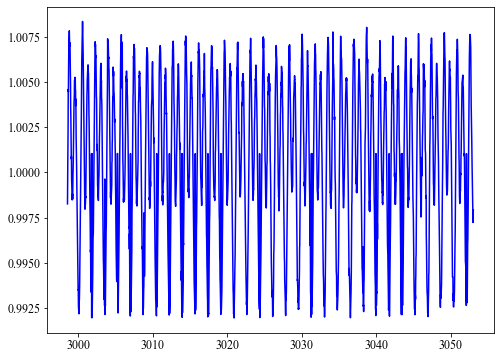

In [388]:
ydata_right_halo = remove_outliers(halo_to_plot[500:3000])
xdata_right_halo = halo_time[500:3000]
plt.plot(xdata_right_halo, ydata_right_halo, 'b-', label='data')

In [389]:
freqs_halo = np.linspace((1/10.),36.,100000) # tess from 100 day period to 360 c/d nyquist
ls_halo_right = LombScargle(xdata_right_halo, ydata_right_halo, normalization='psd')
power_halo_right = ls_halo_right.power(freqs_halo)

In [390]:
ls_halo_right.nterms = 2

In [391]:
1/freqs_halo[np.argmax(power_halo_right)]

0.8681455964176481

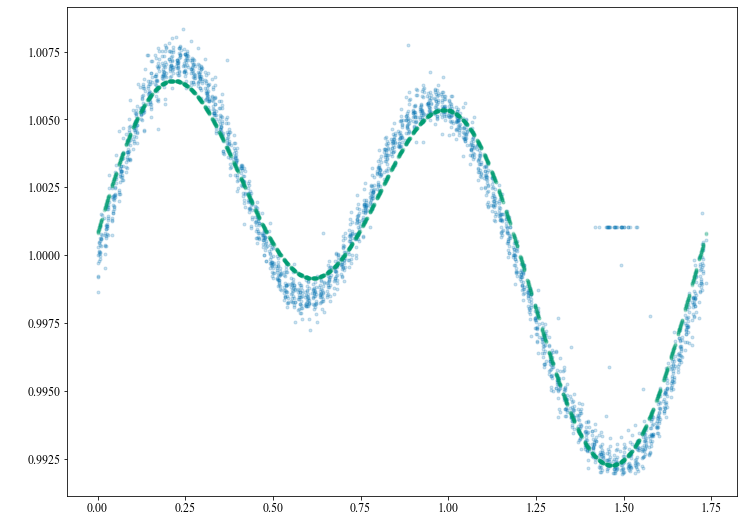

In [392]:
period = 0.8681455964176481
y_fit_right_halo = ls_halo_right.model(xdata_right_halo,1/(2*period))
# y_fit_right, delta_right, ff_right, pp_right = iterative_sine_fit(xdata_right, ydata_right, 2)


fig = plt.figure(figsize=(12.0,9.0))

plt.plot((xdata_right_halo) % (period*2), ydata_right_halo,'.',alpha=0.2 )
plt.plot((xdata_right_halo) % (period*2), y_fit_right_halo,'.',alpha=0.2 )

In [393]:
residuals_right_halo = ydata_right_halo - y_fit_right_halo

In [394]:
freqs_noise_right_halo = np.linspace((1/10.),20.,1000000) # tess from 10 day period to 360 c/d nyquist
ls_noise_right_halo = LombScargle(xdata_right_halo, residuals_right_halo, normalization='psd', fit_mean=False, center_data=True)
power_noise_right_halo = ls_noise_right_halo.power(freqs_noise_right_halo)

Text(0.5, 1.0, 'Halo before eclipse')

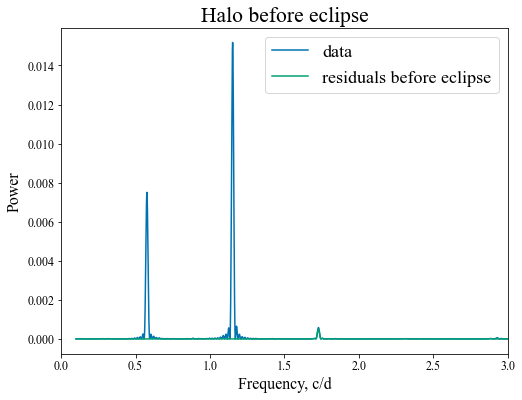

In [395]:
plt.plot(freqs_halo, power_halo_right, label="data")
plt.plot(freqs_noise_right_halo, power_noise_right_halo, label="residuals before eclipse")
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")
plt.title('Halo before eclipse')

Text(0.5, 1.0, 'Halo before eclipse')

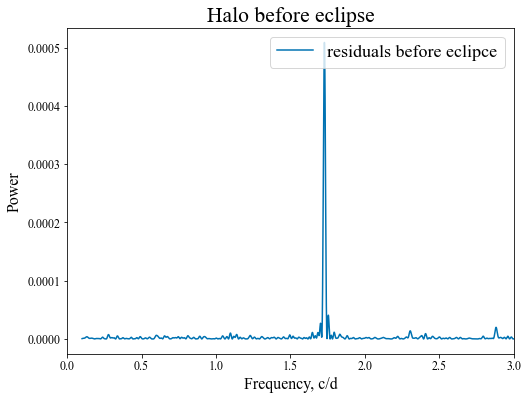

In [396]:
plt.plot(freqs_noise_right_halo, power_noise_right_halo, label="residuals before eclipce")
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")
plt.title('Halo before eclipse')

Before and after for K2:

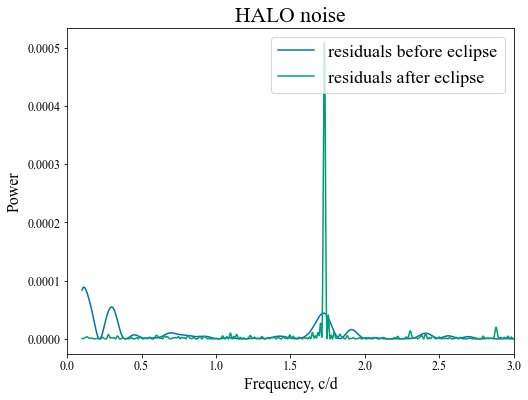

In [397]:
plt.plot(freqs_noise_left_halo, power_noise_left_halo, label="residuals before eclipse")
plt.plot(freqs_noise_right_halo, power_noise_right_halo, label="residuals after eclipse")
plt.title('HALO noise')
plt.xlim(0, 3.)
#plt.ylim(-0.01, 0.06)
plt.ylabel('Power')
plt.xlabel('Frequency, c/d')
plt.legend(loc="upper right")

And now all together:

(1.0, 3.0)

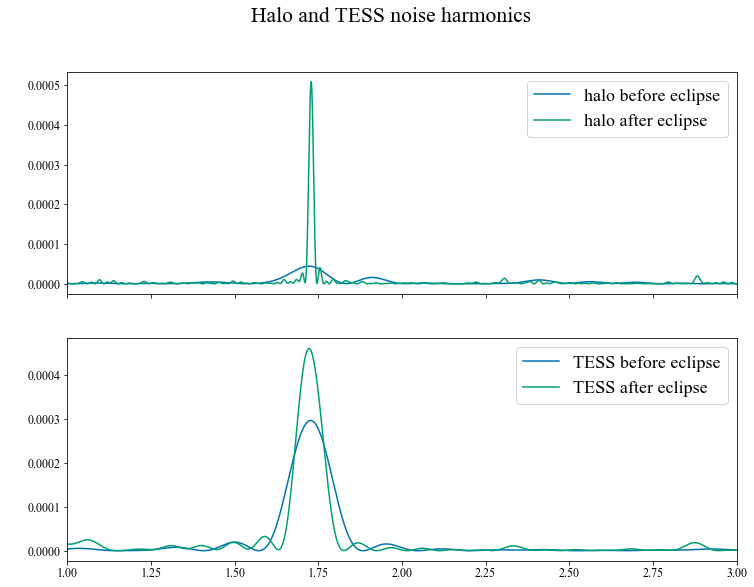

In [398]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12.0,9.0))
fig.suptitle('Halo and TESS noise harmonics')

ax1.plot(freqs_noise_left_halo, power_noise_left_halo, label="halo before eclipse")
ax1.plot(freqs_noise_right_halo, power_noise_right_halo, label="halo after eclipse")
ax1.legend(loc="upper right")

ax2.plot(freqs_noise_left, power_noise_left, label="TESS before eclipse")
ax2.plot(freqs_noise_right, power_noise_right, label="TESS after eclipse")
ax2.legend(loc="upper right")

plt.xlim(1, 3.)

SyntaxError: invalid syntax (3780075675.py, line 1)